# 3. Sensitivity analysis of cell resistance and power capability as a function of electrode loading

Battery Bulletin, in a tweet, raised the topic of power/energy trade-offs related to areal capacity/electrode loading in Li-ion batteries. 

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Honestly, haven&#39;t seen any review article on general recommendation on areal capacity required for power vs energy density applications, What kind of C-rate testing/protocol etc. I understand there is no definitive answer. But a general guide could have been nice!</p>&mdash; Battery Bulletin (@BatteryBulletin) <a href="https://twitter.com/BatteryBulletin/status/1430791252019011588?ref_src=twsrc%5Etfw">August 26, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

This is an interesting and important question which is not all that intuitive, but is crucial in practical cell design. To understand this trade-off fully is very complex and best addressed by more sophisticated modelling and/or a huge array of experiments. However, with this basic cell model, and some extensions to the usage covered in previous we can start to approach this question and draw some illustrative trends.

## 1. Model definition

First, as before the `cellmodel.jl` file needs to be loaded.

In [1]:
# Include the cellmodel.jl file it to load the required packages and functions.
include("cellmodel.jl")

volumetric_energy (generic function with 3 methods)

For this example, I will recreate the same NMC622/graphite cylindrical cell model from the quickstart notebook. First we can define the active materials:

In [2]:
# Active materials

NMC622 = ActiveMaterial("NMC622", 181 ± 4.5, 3.86)  # NMC622 determined from literature
Gr = ActiveMaterial("Graphite", 344 ± 8.6, 0.17)    # Gr determined from literature

# Current collectors
Al14 = CurrentCollector("Al", 14E-4) # 14 µm Al
Cu8 = CurrentCollector("Cu", 8E-4)   # 8 µm Al

# Electrolytes
LP40 = Electrolyte(salt = "LiPF6", solvent = "EC:DEC", concentration = 1.1 ± 0.1)

# Separator
PE_Al12 = Separator(name = "porous PE + alumina", thickness = 12E-4, porosity = 0.44, density = 1.18)

Separator
  name: String "porous PE + alumina"
  thickness: Float64 0.0012
  porosity: Float64 0.44
  density: Float64 1.18


And then we can create the baseline cell model in the same way as before:

In [3]:
example_cylindrical = CylindricalCell(

    name = "Example cylindrical cell",   # A name for the cell

    positive = Electrode(
        ElectrodeComposite(             # An electrode is composed of an electrode composite, which has:
            active_material = NMC622,   # Active material, defined above
            areal_cap = 3.3 ± 0.1,      # An areal capacity, in mAh/cm2
            active_frac = 0.95 ± 0.02,  # An active material fraction, in %
            density = 3.4 ± 0.1         # A (calendered) density, in g/cm3
        ),
        Al14                            # The composite is coated on the current collector, defined above.
    ),
    
    negative = Electrode(               # The negative electrode is similarly defined.
        ElectrodeComposite(
            active_material = Gr,
            areal_cap = (3.3 ± 0.1) * (1.1 ± 0.03),  # Can, if desired, specify n/p ratio in this way.
            active_frac = 0.965 ± 0.01,
            density = 1.6 ± 0.1
        ),
        Cu8
    ),
            
    separator = PE_Al12,                # Separator and electrolyte, as defined above.
    electrolyte = LP40,
    
    # Then, the cell has the following properties and dimensions:
    
    ecap_ratio = 1.7 ± 0.1,              # Electrolyte/capacity ratio, in mL/Ah; used for calculating electrolyte mass
    
    diameter = 2.1, height = 7.0,       # For a 2170 cell
    canthickness = 0.0165,              # Thickness of the cell can, in cm
    candensity = 7.9 ± 0.2,             # Density of the can material, in this case steel
    voiddiameter = 0.25,                # The diameter of the 'void'/empty space in the centre of the winding/jelly roll, in cm
    headspace = 0.6,                    # The distance from the top of the can to the top of the jelly roll, in cm
    extramass = 4 ± 2,                  # A fudge factor; any other unaccounted mass (terminals, safety features), in g
    
    llifactor = 0.94 ± 0.02             # Another fudge factor; adjustment of ideal capacity accounting for first cycle loss.
                                        # 6% first cycle loss (typical) would be 0.94 for this parameter.
)

Example cylindrical cell
NMC622 cathode @ 3.3 ± 0.1 mAh/cm2
4.29 ± 0.22 Ah, 15.84 ± 0.79 Wh
71.1 ± 2.9 g
222.8 ± 9.4 Wh/kg
653.0 ± 33.0 Wh/L


## 2. Estimating impedance and power limitations

I am going to use very simplified methods to calculate the impedance and power limitations for this exercise, which should be noted do not take into account the full complexity of the system. However, I believe they are reasonable enough approximations for this demonstration.

For cell impedance, I am working with data from [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0378775310017477?via%3Dihub) from Argonne National Laboratory, which discusses a simplified method to calculate the area specific impedance (ASI). For this, I have taken their calculated data in Fig. 4, and extracted the data from the lines with DataThief. Then, I have fitted the functions of ASI vs electrode thickness for each electrode to a power law. This I can then put into a function which uses the electrode thickness as calculated by the cell model to calculate an ASI for the cell stack, and then for the full cell by dividing by the "jelly roll area" as also returned by the model.

In [4]:
function estimate_impedance(cell::CylindricalCell)
    
    positive_ASI = 226.24 * (thickness(cell.positive.composite) * 1E4)^-0.975
    negative_ASI = 87.248 * (thickness(cell.negative.composite) * 1E4)^-0.971
    constant_ASI = 14.0
    
    cell_impedance = (positive_ASI + negative_ASI + constant_ASI) / cell.jr_area
    
    return cell_impedance

end

estimate_impedance (generic function with 1 method)

We can check this function works, and find that for the above cell we get an impedance of around 29 mΩ, which is reasonable for a 2170 cell (I have done measurements on 2170 cells and have found fairly similar values).

In [5]:
estimate_impedance(example_cylindrical)

0.02873 ± 0.00096

For power limitations, I have used the concept of "diffusion limited C-rate" as outlined in [this paper](https://onlinelibrary.wiley.com/doi/10.1002/aenm.201902523). For this exercise, I am assuming that the primary limitation for discharge power is electrolyte transport in the porous electrode, which is reasonable especially for relatively compressed, thick electrodes. The diffusion limited C-rate simply quantifies the current above which the Li<sup>+</sup> diffusion in the electrode becomes significantly limiting, and is a function of the electrode porosity, the concentration and diffusion coefficient of Li<sup>+</sup> in the electrolyte, and the thickness of the electrode.

This we can also create a function for, which takes the cell model as an input and uses the appropriate parameters in the calculation.

In [6]:
function dlc_positive(cell::CylindricalCell)
   
   j_lim = 2 * 96485 * 2E-6 * (0.32 ± 0.02)^2 * cell.electrolyte.concentration / 
    thickness(cell.positive.composite)
   
   return j_lim/cell.positive.composite.areal_cap
    
end

dlc_positive (generic function with 1 method)

We can check this function works, and find that for this cell the diffusion-limited C-rate is around 2.3 C (corresponding to a discharge time of around 26 minutes). I'm not sure how accurate that is at this point, but again it sounds reasonable for now so I'll go with it.

In [7]:
dlc_positive(example_cylindrical)

2.33 ± 0.4

## 3. Setting up and running the sensitivity analysis

In the second notebook we looked at comparing different active materials. Here, we would like to look at the effect of a range of different electrode thicknesses. To do this we will again make a function which builds a model of the same cylindrical cell, but where we can change some parameters with variables in a `for` loop. So first I'll make a function called `cylindrical_sensitivity()` which builds a model, and then check it works:

In [8]:
function cylindrical_sensitivity(;
        
    name = "Example cylindrical cell",   # A name for the cell

    positive = Electrode(
        ElectrodeComposite(             
            active_material = NMC622,   
            areal_cap = 3.3 ± 0.1,      
            active_frac = 0.95 ± 0.02,  
            density = 3.4 ± 0.1         
        ),
        Al14                            
    ),
    
    negative = Electrode(               
        ElectrodeComposite(
            active_material = Gr,
            areal_cap = (3.3 ± 0.1) * (1.1 ± 0.03),  
            active_frac = 0.965 ± 0.01,
            density = 1.6 ± 0.1
        ),
        Cu8
    ),
            
    separator = PE_Al12,                
    electrolyte = LP40,
    
    ecap_ratio = 1.7 ± 0.1,             
    
    diameter = 2.1, height = 7.0,       
    canthickness = 0.0165,              
    candensity = 7.9 ± 0.2,             
    voiddiameter = 0.25,                
    headspace = 0.6,                    
    extramass = 4 ± 2,                  
    
    llifactor = 0.94 ± 0.02  
        
    )
    
    cell = CylindricalCell(
    
        name = name,
        positive = positive,
        negative = negative,
        separator = separator,
        electrolyte = electrolyte,
        ecap_ratio = ecap_ratio,
        diameter = diameter, height = height,
        canthickness = canthickness,
        candensity = candensity,
        voiddiameter = voiddiameter,
        headspace = headspace,
        extramass = extramass,
        llifactor = llifactor
    )
    
    return cell
end

cylindrical_sensitivity()

Example cylindrical cell
NMC622 cathode @ 3.3 ± 0.1 mAh/cm2
4.29 ± 0.22 Ah, 15.84 ± 0.79 Wh
71.1 ± 2.9 g
222.8 ± 9.4 Wh/kg
653.0 ± 33.0 Wh/L


Now, we can perform the sensitivity analysis by putting the `cylindrical_sensitivity()` function into a `for` loop, where we vary the areal capacity in mAh/cm². In this case, it can be very useful to set the negative electrode capacity using the same number as for the positive electrode, multiplied by an appropriate n/p ratio. In each iteration of the loop, I want some of the key numbers (loading, energy densities, impedance, DLC, and power densities - which I can calculate by just multiplying the energy densities by the DLC) outputted into suitable objects so I can plot them.

In [9]:
loading = Measurement{Float64}[]
energy_density_grav = Measurement{Float64}[]
jr_area = Measurement{Float64}[]
impedance = Measurement{Float64}[]
dlc = Measurement{Float64}[]
power_density_vol = Measurement{Float64}[]
power_density_grav = Measurement{Float64}[]
energy_density_vol = Measurement{Float64}[]

for areal_cap in 2:0.1:5.5

    cell = cylindrical_sensitivity(

        positive = Electrode(
            ElectrodeComposite(             
                active_material = NMC622,   
                areal_cap = areal_cap,      
                active_frac = 0.95 ± 0.02,  
                density = 3.4 ± 0.1         
            ),
            Al14                            
        ),
    
        negative = Electrode(               
            ElectrodeComposite(
                active_material = Gr,
                areal_cap = areal_cap * (1.1 ± 0.03),  
                active_frac = 0.965 ± 0.01,
                density = 1.6 ± 0.1
            ),
            Cu8 
        )
)
    
    push!(loading, areal_cap)
    push!(energy_density_grav, gravimetric_energy(cell))
    push!(jr_area, cell.jr_area)
    push!(impedance, estimate_impedance(cell) * 1000)
    push!(dlc, dlc_positive(cell))
    push!(power_density_vol, volumetric_energy(cell) * dlc_positive(cell))
    push!(power_density_grav, gravimetric_energy(cell) * dlc_positive(cell))
    push!(energy_density_vol, volumetric_energy(cell))
    
end

## 4. Plotting the results

For this, I will use Plots.jl, which you will need to install if you do not have it already.

In [10]:
using Plots

### Cell-level energy density vs areal capacity

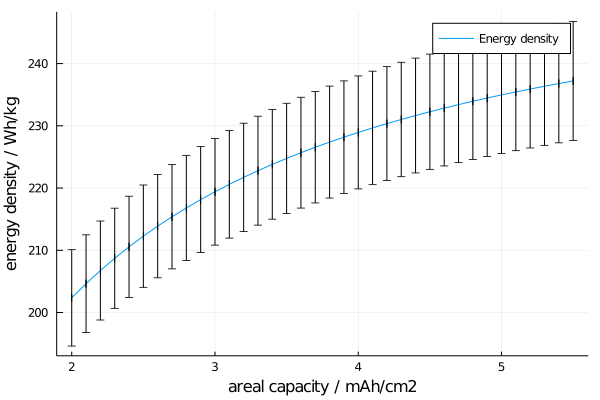

In [11]:
plot(loading, energy_density_grav, label = "Energy density", xlabel = "areal capacity / mAh/cm2",
ylabel = "energy density / Wh/kg")

### Jelly roll area vs areal capacity

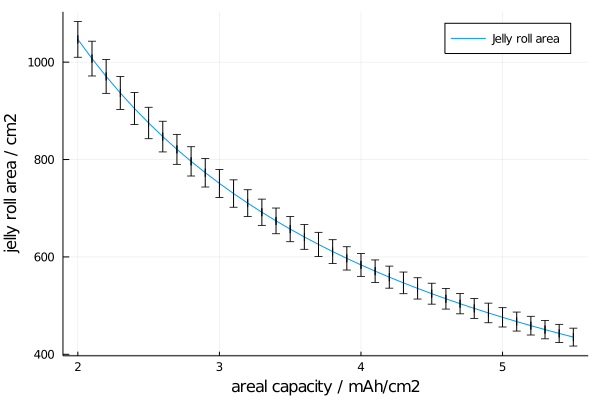

In [12]:
plot(loading, jr_area, label = "Jelly roll area", xlabel = "areal capacity / mAh/cm2", 
    ylabel = "jelly roll area / cm2")

### Cell impedance vs areal capacity

From this plot you can see that although ASI decreases with thickness (as in the data extracted previously), the cell impedance increases with areal capacity, because of the decreasing jelly roll area in the cell.

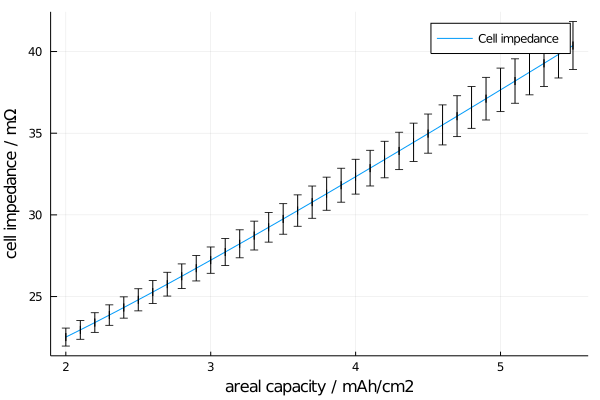

In [13]:
plot(loading, impedance, label = "Cell impedance", xlabel = "areal capacity / mAh/cm2",
ylabel = "cell impedance / mΩ")

### DLC vs areal capacity

DLC varies from around 6 C at the thinnest electrodes to ~0.8C for the thickest electrodes.

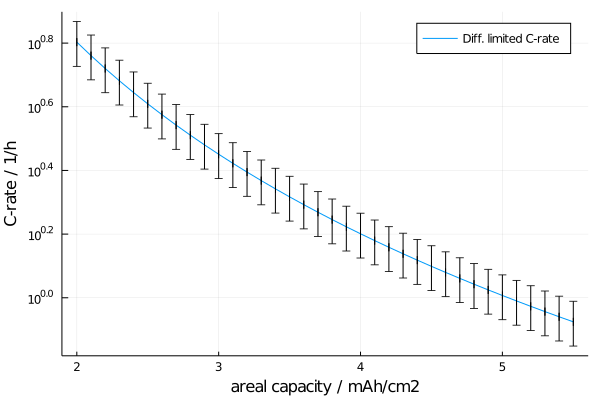

In [14]:
plot(loading, dlc, yaxis=:log10, label = "Diff. limited C-rate", xlabel = "areal capacity / mAh/cm2",
    ylabel = "C-rate / 1/h")

### Cell impedance and DLC vs energy density

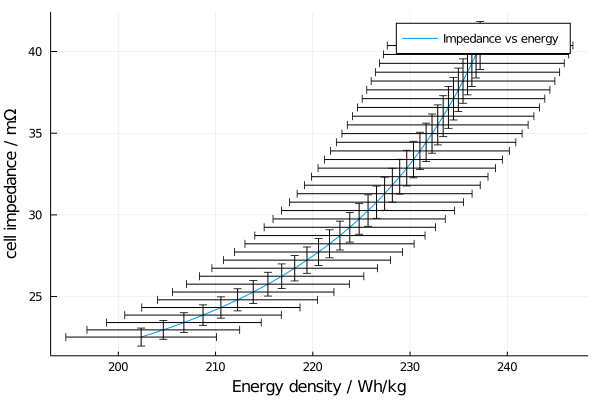

In [15]:
plot(energy_density_grav, impedance, label = "Impedance vs energy", xlabel = "Energy density / Wh/kg",
ylabel = "cell impedance / mΩ")

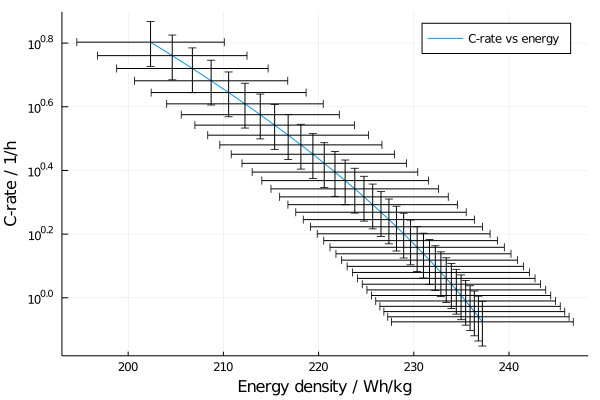

In [16]:
plot(energy_density_grav, dlc, yaxis=:log10, label = "C-rate vs energy", xlabel = "Energy density / Wh/kg",
ylabel = "C-rate / 1/h")

### Ragone plots

We can make some illustrative Ragone plots (power density vs energy density) based on multiplying the energy density (Wh/kg or Wh/L) by the limiting C-rate (1/h).

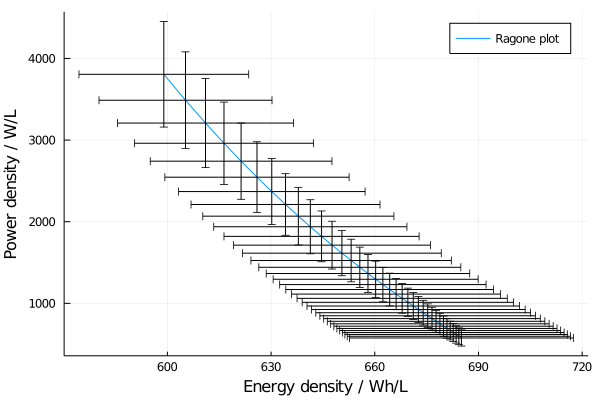

In [17]:
plot(energy_density_vol, power_density_vol, label = "Ragone plot", xlabel = "Energy density / Wh/L",
ylabel = "Power density / W/L")

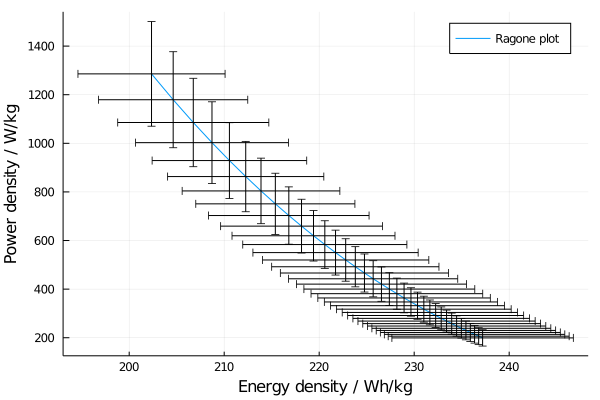

In [18]:
plot(energy_density_grav, power_density_grav, label = "Ragone plot", xlabel = "Energy density / Wh/kg",
ylabel = "Power density / W/kg")